In [1]:
import os
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/home/ajai-krishna/work/Phenocam_d3/ndvi/APU_pos_01_2026_02_21_11_11_41.csv',header=None)
# df.values.flatten()
# (df.dtypes == "float64").all()

In [3]:
output_grid_dir = '/home/ajai-krishna/work/Phenocam_d3/Plots'

In [4]:
df = df.apply(pd.to_numeric, errors="coerce")

# Optional: Replace NaN with 0 (or keep them)
df = df.fillna(np.nan)

values = df.values.flatten()

print(values.dtype)

float64


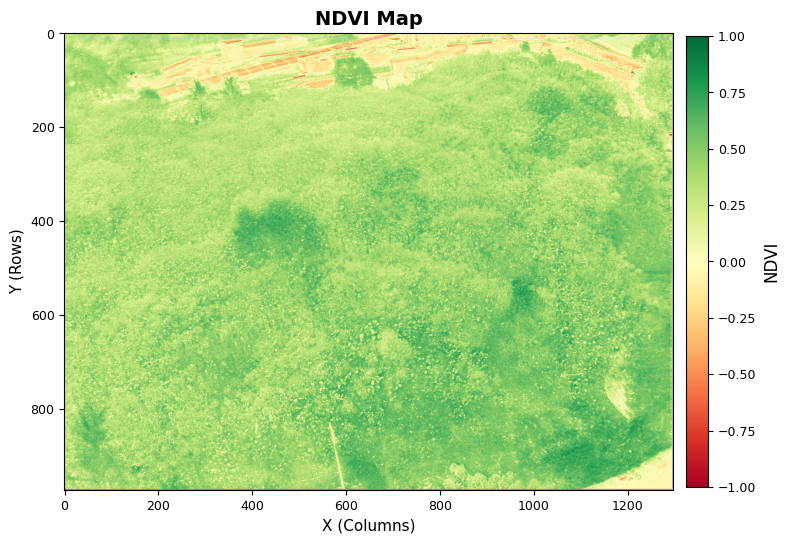

In [5]:
ndvi = df.values

plt.figure(figsize=(8, 8))

img = plt.imshow(
    ndvi,
    cmap="RdYlGn",
    vmin=-1,
    vmax=1,
    aspect="equal"   # keeps square pixels
)

# Smaller colorbar
cbar = plt.colorbar(
    img,
    fraction=0.035,   # controls width
    pad=0.02          # space between plot & colorbar
)
cbar.set_label("NDVI", fontsize=12)
cbar.ax.tick_params(labelsize=9)

plt.title("NDVI Map", fontsize=14, weight="bold")
plt.xlabel("X (Columns)", fontsize=11)
plt.ylabel("Y (Rows)", fontsize=11)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

mid_col = len(df.columns)//2
mid_row = len(df)//2

df1 = df.loc[ :mid_row-1, :mid_col-1]
df2 = df.loc[mid_row: , :mid_col-1]
df3 = df.loc[ :mid_row-1, mid_col: ]
df4 = df.loc[mid_row: , mid_col: ]
print(np.mean(df1.values))
print(np.mean(df2.values))
print(np.mean(df3.values))
print(np.nanmean(df4.values))

In [6]:
def grid_statistics(df, n_rows, n_cols, stat):
    """
    Split dataframe into n_rows × n_cols grid
    and compute statistic for each block.
    
    stat options: "mean", "sum", "median", "std"
    """

    row_splits = np.array_split(df.index, n_rows)
    col_splits = np.array_split(df.columns, n_cols)

    results = {}

    for i, rows in enumerate(row_splits):
        for j, cols in enumerate(col_splits):
            block = df.loc[rows, cols]

            if stat == "mean":
                value = block.stack().mean()
            elif stat == "sum":
                value = block.stack().sum()
            elif stat == "median":
                value = block.stack().median()
            elif stat == "std":
                value = block.stack().std()
            else:
                raise ValueError("Invalid stat type")

            results[f"Grid_{i+1}_{j+1}"] = value

    return results

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def visualize_grid_statistics(df, n_rows, n_cols, stat="mean", show_plot=True):
    """
    Split dataframe into n_rows × n_cols grid,
    compute statistic for each block,
    optionally visualize,
    and return results as DataFrame.

    stat options: "mean", "sum", "median", "std"
    """

    # Ensure numeric
    df = df.apply(pd.to_numeric, errors="coerce")

    data = df.values
    rows, cols = data.shape

    # Split indices
    row_splits = np.array_split(df.index, n_rows)
    col_splits = np.array_split(df.columns, n_cols)

    results = []

    for i, r_idx in enumerate(row_splits):
        for j, c_idx in enumerate(col_splits):

            block = df.loc[r_idx, c_idx].values.flatten()
            block = block[~np.isnan(block)]  # remove NaN

            if len(block) == 0:
                value = np.nan
            else:
                if stat == "mean":
                    value = np.mean(block)
                elif stat == "sum":
                    value = np.sum(block)
                elif stat == "median":
                    value = np.median(block)
                elif stat == "std":
                    value = np.std(block)
                else:
                    raise ValueError("Invalid stat type")

            results.append({
                "row": i + 1,
                "col": j + 1,
                "value": float(value) if not np.isnan(value) else None
            })

    result_df = pd.DataFrame(results)

    # ------------------ PLOTTING ------------------
    if show_plot:

        fig, ax = plt.subplots(figsize=(8, 8))

        img = ax.imshow(
            data,
            cmap="RdYlGn",
            vmin=-1,
            vmax=1,
            origin="upper",
            extent=[0, cols, rows, 0],
            interpolation="nearest"
        )

        # Smaller colorbar
        cbar = plt.colorbar(img, fraction=0.035, pad=0.02)
        cbar.set_label("NDVI")

        # Grid edges
        row_edges = np.linspace(0, rows, n_rows + 1)
        col_edges = np.linspace(0, cols, n_cols + 1)

        # Draw grid lines
        for r in row_edges:
            ax.hlines(r, xmin=0, xmax=cols, colors="black", linewidth=1)

        for c in col_edges:
            ax.vlines(c, ymin=0, ymax=rows, colors="black", linewidth=1)

        # Add statistic text
        for item in results:
            i = item["row"] - 1
            j = item["col"] - 1

            r_center = (row_edges[i] + row_edges[i+1]) / 2
            c_center = (col_edges[j] + col_edges[j+1]) / 2

            if item["value"] is not None:
                ax.text(
                    c_center,
                    r_center,
                    f"{item['value']:.3f}",
                    ha="center",
                    va="center",
                    fontsize=10,
                    weight="bold",
                    color="black"
                )

        ax.set_xlim(0, cols)
        ax.set_ylim(rows, 0)

        ax.set_title(f"NDVI Grid Statistics ({stat.upper()})", weight="bold")
        ax.set_xlabel("X (Columns)")
        ax.set_ylabel("Y (Rows)")

        plt.tight_layout()
        save_path = os.path.join(output_grid_dir, "grid_plot_ndvi.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Grid plot saved to {save_path}")

    return result_df

✅ Grid plot saved to /home/ajai-krishna/work/Phenocam_d3/Plots/grid_plot_ndvi.png


,row,col,value
0,1,1,0.296073
1,1,2,0.332765
2,2,1,0.398808
3,2,2,0.486115


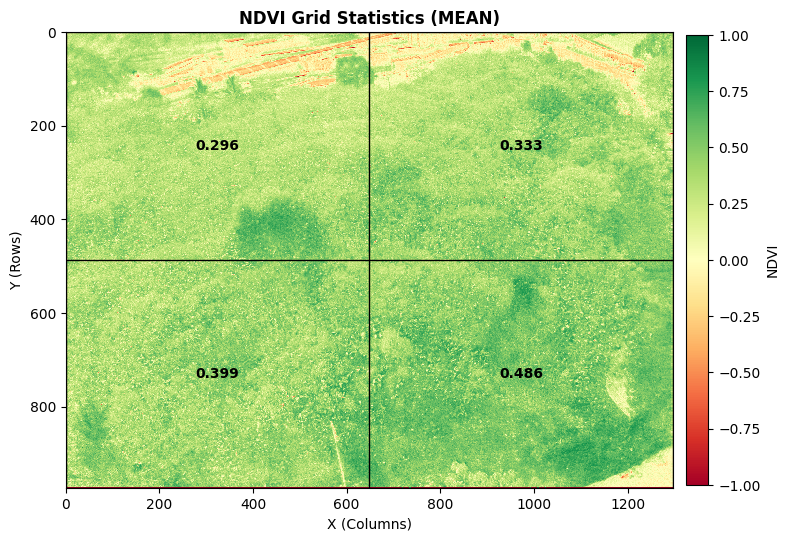

In [8]:
df_grid_2 = visualize_grid_statistics(df,2,2,"mean")
df_grid_2


In [9]:
df_grid_2.to_json(
    os.path.join(output_grid_dir, "grid_plot_ndvi.json"),
    orient="records",
    indent=4
)

In [19]:
import os
import json

mean_val = df_grid_2.mean()[2]
min_val = df_grid_2.min()[2]
max_val = df_grid_2.max()[2]

json_stats = {
    "mean": float(mean_val),
    "min": float(min_val),
    "max": float(max_val)
}

output_path = os.path.join(output_grid_dir, "grid_plot_ndvi_stats.json")

with open(output_path, "w") as f:
    json.dump(json_stats, f, indent=4)

print(f'✅ Grid statistics saved to {output_path}')

✅ Grid statistics saved to /home/ajai-krishna/work/Phenocam_d3/Plots/grid_plot_ndvi_stats.json


/tmp/ipykernel_8763/797661461.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_val = df_grid_2.mean()[2]
/tmp/ipykernel_8763/797661461.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_val = df_grid_2.min()[2]
/tmp/ipykernel_8763/797661461.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = df_grid_2.max()[2]
